# Introduction

The model is a Generative Adversarial Network (GAN) that generates molecular structures in the form of SMILES (Simplified Molecular Input Line Entry System) strings. The model consists of two main components: a generator and a discriminator.

The generator takes a latent vector as input and generates a sequence of tokens representing a SMILES string. The discriminator takes a SMILES string as input and outputs a probability that the string was generated by the real data distribution rather than the generator.

The generator and discriminator are trained together using a two-step process. In the first step, the discriminator is trained to distinguish between real and fake SMILES strings. In the second step, the generator is trained to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function, which is the difference between the discriminator's output for the generated string and the baseline reward.

The training process involves the following steps:

1. Sample a batch of real SMILES strings from the training data.
2. Sample a batch of latent vectors from the latent space.
3. Generate a batch of fake SMILES strings using the generator and the latent vectors.
4. Train the discriminator to distinguish between real and fake SMILES strings.
5. Train the generator to generate SMILES strings that are indistinguishable from real SMILES strings by maximizing the reward function.
6. Repeat steps 2-5 for a specified number of training steps.

After training, the generator can be used to generate new molecular structures by sampling latent vectors from the latent space and passing them through the generator. The output of the generator is a sequence of tokens representing a SMILES string, which can be converted to a molecular structure using a chemical library such as RDKit.

In the code below, the `MolGen` class is used to train the GAN on a dataset of molecular structures in SMILES format. The `generate_n` method of the `MolGen` class can be used to generate a specified number of new molecular structures, and the `Chem.MolFromSmiles` function from the RDKit library can be used to convert the generated SMILES strings to molecular structures.

# Dataset

In [ ]:
import pandas as pd
df = pd.read_csv("/kaggle/working/molgen_master/molgen-master/qm9.csv")

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
!pip install -r /kaggle/working/molgen_master/molgen-master/requirement.txt

In [ ]:
!pip install --upgrade huggingface-hub==0.24.0

In [ ]:
import huggingface_hub
print(huggingface_hub.__version__)

# Loading Data and Initializing 

# Generating Smiles

The none in `mol_list` indicates that it is not valid.

In [1]:
# layers.py

import torch
from allennlp.modules.feedforward import FeedForward
from allennlp.modules.seq2seq_encoders import (LstmSeq2SeqEncoder,
                                               PytorchTransformer)
from torch import nn
from torch.distributions import Categorical
from torch.nn.modules.activation import Sigmoid

class Generator(nn.Module):

    def __init__(self, latent_dim, vocab_size, start_token, end_token):
        """Generator

        Args:
            latent_dim (int): [description]
            vocab_size (int): vocab size without padding
            start_token ([int]): start token (without padding idx)
            end_token ([int]): end token (without padding idx)
        """

        super().__init__()

        # (-1) we do not need pad token for the generator
        self.vocab_size = vocab_size
        self.start_token = start_token
        self.end_token = end_token

        self.embedding_layer = nn.Embedding(self.vocab_size, latent_dim)

        self.project = FeedForward(
            input_dim=latent_dim,
            num_layers=2,
            hidden_dims=[latent_dim * 2, latent_dim * 2],
            activations=[nn.ReLU(), nn.ELU(alpha=0.1)],
            dropout=[0.1, 0.1]
        )

        self.rnn = nn.LSTMCell(latent_dim, latent_dim)

        self.output_layer = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(latent_dim * 2, vocab_size - 1)
        )

    def forward(self, z, num_atoms, max_len=20):
        """[summary]

        Args:
            z (torch.Tensor): [description]
            num_atoms (int): number of atoms
            max_len (int, optional): [description]. Defaults to 20.

        Returns:
            dict: x [B, max_len], log_probabilities [B, max_len, vocab], entropies [B,]
        """

        batch_size = z.shape[0]

        # start of sequence
        starts = torch.full(
            size=(batch_size,), fill_value=self.start_token, device=z.device).long()

        # embed_start
        emb = self.embedding_layer(starts)

        x = []
        log_probabilities = []
        entropies = []

        h, c = self.project(z).chunk(2, dim=1)

        for i in range(max_len):

            # new state
            h, c = self.rnn(emb, (h, c))

            # prediction
            logits = self.output_layer(h)

            # create dist
            dist = Categorical(logits=logits)

            # sample
            sample = dist.sample()

            # append prediction
            x.append(sample)

            # append log prob
            log_probabilities.append(dist.log_prob(sample))

            # append entropy
            entropies.append(dist.entropy())

            # new embedding
            emb = self.embedding_layer(sample)

        # stack along sequence dim
        x = torch.stack(x, dim=1)
        log_probabilities = torch.stack(log_probabilities, dim=1)
        entropies = torch.stack(entropies, dim=1)

        # keep only valid lengths (before EOS)
        end_pos = (x == self.end_token).float().argmax(dim=1).cpu()

        # sequence length is end token position + 1
        seq_lengths = end_pos + 1

        # if end_pos = 0 => put seq_length = max_len
        seq_lengths.masked_fill_(seq_lengths == 1, max_len)

        # select up to length
        _x = []
        _log_probabilities = []
        _entropies = []
        for x_i, logp, ent, length in zip(x, log_probabilities, entropies, seq_lengths):
            _x.append(x_i[:length])
            _log_probabilities.append(logp[:length])
            _entropies.append(ent[:length].mean())

        x = torch.nn.utils.rnn.pad_sequence(
            _x, batch_first=True, padding_value=-1)

        x = x + 1  # add padding token

        return {'x': x, 'log_probabilities': _log_probabilities, 'entropies': _entropies}

class RecurrentDiscriminator(nn.Module):

    def __init__(self, hidden_size, vocab_size, start_token, bidirectional=True):
        """Reccurent discriminator

        Args:
            hidden_size (int): model hidden size
            vocab_size (int): vocabulary size
            bidirectional (bool, optional): [description]. Defaults to True.
        """

        super().__init__()

        self.start_token = start_token

        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)

        self.rnn = LstmSeq2SeqEncoder(
            hidden_size, hidden_size, num_layers=1, bidirectional=bidirectional)

        if bidirectional:
            hidden_size = hidden_size * 2

        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """[summary]

        Args:
            x ([type]): [description]

        Returns:
            [type]: [description]
        """

        batch_size, _ = x.size()

        # append start token to the input
        starts = torch.full(
            size=(batch_size, 1), fill_value=self.start_token, device=x.device).long()

        x = torch.cat([starts, x], dim=1)

        mask = x > 0

        # embed input [batch_size, max_len, hidden_size]
        emb = self.embedding(x)

        # contextualize representation
        x = self.rnn(emb, mask)

        # prediction for each sequence
        out = self.fc(x).squeeze(-1)  # [B, max_len]

        return {'out': out[:, 1:], 'mask': mask.float()[:, 1:]}

# tokenizer.py

import torch

class Tokenizer(object):

    def __init__(self, data):

        unique_char = list(set(''.join(data))) + ['<eos>'] + ['<sos>']

        self.mapping = {'<pad>': 0}

        for i, c in enumerate(unique_char, start=1):
            self.mapping[c] = i

        self.inv_mapping = {v: k for k, v in self.mapping.items()}

        self.start_token = self.mapping['<sos>']

        self.end_token = self.mapping['<eos>']

        self.vocab_size = len(self.mapping.keys())

    def encode_smile(self, mol, add_eos=True):

        out = [self.mapping[i] for i in mol]

        if add_eos:
            out = out + [self.end_token]

        return torch.LongTensor(out)

    def batch_tokenize(self, batch):

        out = map(lambda x: self.encode_smile(x), batch)

        return torch.nn.utils.rnn.pad_sequence(list(out), batch_first=True)


In [2]:
# model.py

import numpy as np
import torch
import torch.nn.functional as F
from rdkit import Chem, RDLogger
from torch import nn
from torch.nn.utils import clip_grad_value_
from torch.utils.data import DataLoader


RDLogger.DisableLog('rdApp.*')

class MolGen(nn.Module):

    def __init__(self, data, hidden_dim=128, lr=1e-3, device='cpu'):
        """[summary]

        Args:
            data (list[str]): [description]
            hidden_dim (int, optional): [description]. Defaults to 128.
            lr ([type], optional): learning rate. Defaults to 1e-3.
            device (str, optional): 'cuda' or 'cpu'. Defaults to 'cpu'.
        """
        super().__init__()

        self.device = device

        self.hidden_dim = hidden_dim

        self.tokenizer = Tokenizer(data)

        self.generator = Generator(
            latent_dim=hidden_dim,
            vocab_size=self.tokenizer.vocab_size - 1,
            start_token=self.tokenizer.start_token - 1,  # no need token
            end_token=self.tokenizer.end_token - 1,
        ).to(device)

        self.discriminator = RecurrentDiscriminator(
            hidden_size=hidden_dim,
            vocab_size=self.tokenizer.vocab_size,
            start_token=self.tokenizer.start_token,
            bidirectional=True
        ).to(device)

        self.generator_optim = torch.optim.Adam(
            self.generator.parameters(), lr=lr)

        self.discriminator_optim = torch.optim.Adam(
            self.discriminator.parameters(), lr=lr)

        self.b = 0.  # baseline reward

    def sample_latent(self, batch_size):
        """Sample from latent space

        Args:
            batch_size (int): number of samples

        Returns:
            torch.Tensor: [batch_size, self.hidden_dim]
        """
        return torch.randn(batch_size, self.hidden_dim).to(self.device)

    def discriminator_loss(self, x, y):
        """Discriminator loss

        Args:
            x (torch.LongTensor): input sequence [batch_size, max_len]
            y (torch.LongTensor): sequence label (zeros from generatoe, ones from real data)
                                  [batch_size, max_len]

        Returns:
            loss value
        """

        y_pred, mask = self.discriminator(x).values()

        loss = F.binary_cross_entropy(
            y_pred, y, reduction='none') * mask

        loss = loss.sum() / mask.sum()

        return loss

    def train_step(self, x, num_atoms):
        """One training step

        Args:
            x (torch.LongTensor): sample form real distribution
            num_atoms (int): number of atoms
        """

        batch_size, len_real = x.size()

        # create real and fake labels
        x_real = x.to(self.device)
        y_real = torch.ones(batch_size, len_real).to(self.device)

        # sample latent var
        z = self.sample_latent(batch_size)
        generator_outputs = self.generator.forward(z, num_atoms, max_len=20)
        x_gen, log_probs, entropies = generator_outputs.values()

        # label for fake data
        _, len_gen = x_gen.size()
        y_gen = torch.zeros(batch_size, len_gen).to(self.device)

        #####################
        # Train Discriminator
        #####################

        self.discriminator_optim.zero_grad()

        # disc fake loss
        fake_loss = self.discriminator_loss(x_gen, y_gen)

        # disc real loss
        real_loss = self.discriminator_loss(x_real, y_real)

        # combined loss
        discr_loss = 0.5 * (real_loss + fake_loss)
        discr_loss.backward()

        # clip grad
        clip_grad_value_(self.discriminator.parameters(), 0.1)

        # update params
        self.discriminator_optim.step()

        # ###############
        # Train Generator
        # ###############

        self.generator_optim.zero_grad()

        # prediction for generated x
        y_pred, y_pred_mask = self.discriminator(x_gen).values()

        # Reward (see the ref paper)
        R = (2 * y_pred - 1)

        # reward len for each sequence
        lengths = y_pred_mask.sum(1).long()

        # list of rew of each sequences
        list_rewards = [rw[:ln] for rw, ln in zip(R, lengths)]

        # compute - (r - b) log x
        generator_loss = []
        for reward, log_p in zip(list_rewards, log_probs):

            # substract the baseline
            reward_baseline = reward - self.b

            generator_loss.append((- reward_baseline * log_p).sum())

        # mean loss + entropy reg
        generator_loss = torch.stack(generator_loss).mean() - \
            sum(entropies) * 0.01 / batch_size

        # baseline moving average
        with torch.no_grad():
            mean_reward = (R * y_pred_mask).sum() / y_pred_mask.sum()
            self.b = 0.9 * self.b + (1 - 0.9) * mean_reward

        generator_loss.backward()

        clip_grad_value_(self.generator.parameters(), 0.1)

        self.generator_optim.step()

        return {'loss_disc': discr_loss.item(), 'mean_reward': mean_reward}

    def create_dataloader(self, data, batch_size=128, shuffle=True, num_workers=5):
        """create a dataloader

        Args:
            data (list[str]): list of molecule smiles
            batch_size (int, optional): Defaults to 128.
            shuffle (bool, optional): Defaults to True.
            num_workers (int, optional): Defaults to 5.

        Returns:
            torch.data.DataLoader: a torch dataloader
        """

        return DataLoader(
            data,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=self.tokenizer.batch_tokenize,
            num_workers=num_workers
        )

    def train_n_steps(self, train_loader, max_step=10000, evaluate_every=50):
        """Train for max_step steps

        Args:
            train_loader (torch.data.DataLoader): dataloader
            max_step (int, optional): Defaults to 10000.
            evaluate_every (int, optional): Defaults to 50.
        """

        iter_loader = iter(train_loader)

        # best_score = 0.0

        for step in range(max_step):

            try:
                batch = next(iter_loader)
            except:
                iter_loader = iter(train_loader)
                batch = next(iter_loader)

            # model update
            self.train_step(batch, num_atoms=10)  # specify the number of atoms

            if step % evaluate_every == 0:

                self.eval()
                score = self.evaluate_n(100)
                self.train()

                # if score > best_score:
                #     self.save_best()
                #     print('saving')
                #     best_score = score

                print(f'valid = {score: .2f}')

    def get_mapped(self, seq):
        """Transform a sequence of ids to string

        Args:
            seq (list[int]): sequence of ids

        Returns:
            str: string output
        """
        return ''.join([self.tokenizer.inv_mapping[i] for i in seq])

    @torch.no_grad()
    def generate_n(self, n, num_atoms):
        """Generate n molecules

        Args:
            n (int)
            num_atoms (int): number of atoms

        Returns:
            list[str]: generated molecules
        """

        z = torch.randn((n, self.hidden_dim)).to(self.device)

        x = self.generator(z, num_atoms)['x'].cpu()

        lengths = (x > 0).sum(1)

        # l - 1 because we exclude end tokens
        return [self.get_mapped(x[:l-1].numpy()) for x, l in zip(x, lengths)]

    def evaluate_n(self, n):
        """Evaluation: frequence of valid molecules using rdkit

        Args:
            n (int): number of sample

        Returns:
            float: requence of valid molecules
        """

        pack = self.generate_n(n, num_atoms=10)  # specify the number of atoms

        print(pack[:2])

        valid = np.array([Chem.MolFromSmiles(k) is not None for k in pack])

        return valid.mean()

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


['(C+2Nc(oHN2c+5CC)O)', 'H+o51c[3nFc']
valid =  0.02
['CC=(=', 'COOc=HCoC=CH=c=COOO']
valid =  0.05
['1CN1C', 'CC1C=1NCC=C1#(C1=Cc']
valid =  0.19
['CCC1C11', 'CNC']
valid =  0.19
['CCOCOCC1CN', 'CCC1CCCCC1NC2N[2NN']
valid =  0.12
['C1CC1C', 'CCC1OC#C1n=C1)NN1N1']
valid =  0.06
['CC1OCCOC1NC1', 'CC1OCO2CC1OC']
valid =  0.04
['C1CCCC1C1', 'CCC1NC=CCCC1C2']
valid =  0.19
['CC1N#CN111', 'NN1NC1C2']
valid =  0.12
['NC1C12C1CCC2C1O=CNC', '2CC12CC1OC)C12C1=CC']
valid =  0.12
['OC1CC1CC11O', 'COC1COCC1O']
valid =  0.15


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


['OC#COC1)OC=', 'N#CCCn1O']
valid =  0.08
['OCC1CCC2N', 'OCC11]2CC1N']
valid =  0.16
['N#CN2C', 'N#O=COC=N']
valid =  0.09
['CC1NC2CC12', 'CC12CCCOC1O']
valid =  0.16
['C#CC1C=N', 'C1C2#CC1C2NC21C2N']
valid =  0.14
['CN#C11C21CNC21COC1=', 'N=C1OC1C1C12OC1=N']
valid =  0.10
['CCC1NC2C1CN=', 'COC1CC2CC13CN2']
valid =  0.17
['CC11O=CCC1=C2', 'OC1C1C2CC1=O']
valid =  0.14
['N=CC12CCOC1C2COC=C1', 'CC=O=C1COC2C=C1']
valid =  0.15
['OC1CCOC1', 'OC1=OC1CC2C1']
valid =  0.19
['OC1CC2CC1C=O', 'CCC1OCC1OCC1COC1']
valid =  0.26
['N#CCC1CC2NC2C1CO', 'CC1NC12OCC=CC12']
valid =  0.24
['CC=OCC12CC1COC2O', 'N#CCC1C2CCC2CC12']
valid =  0.40
['O=C1C2CC1C2C', 'CC12COCC1CC2C']
valid =  0.25
['COC1C2CNC1CC2C', 'COC1NC1NC1CNC1']
valid =  0.40
['O=CCOCC1OCCC2ON1', 'OCNC1CNC1CO']
valid =  0.58
['COC1CC2NC12', 'C#NC1CC1=OC#N']
valid =  0.32
['CC1COC11C#C', 'N#CC1OC1CC1C1NC1C2C']
valid =  0.37
['CC1C2CC12C3C', 'C#CC1CC2CCO21']
valid =  0.55
['CCC1COC1C#O', 'OC1CNC1C=O']
valid =  0.55
['CC1COC11CCOC1', 'C#CC1COC1

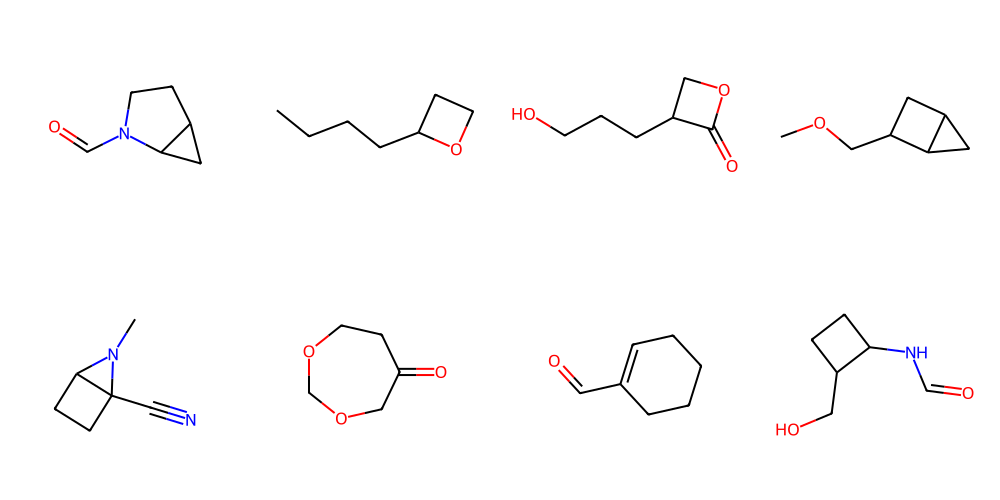

In [5]:

# train.py

from rdkit import Chem

# load data
data = []
with open('/kaggle/working/molgen_master/molgen-master/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# create model
gan_mol = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")
# create dataloader
loader = gan_mol.create_dataloader(data, batch_size=128, shuffle=True, num_workers=10)

# train model for 10000 steps
gan_mol.train_n_steps(loader, max_step=20000, evaluate_every=100)
gan_mol.eval()

print('ok')
# After training
# generate Smiles molecules with a specific number of atoms
num_atoms = 10  # specify the number of atoms
smiles_list = gan_mol.generate_n(8, num_atoms)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)


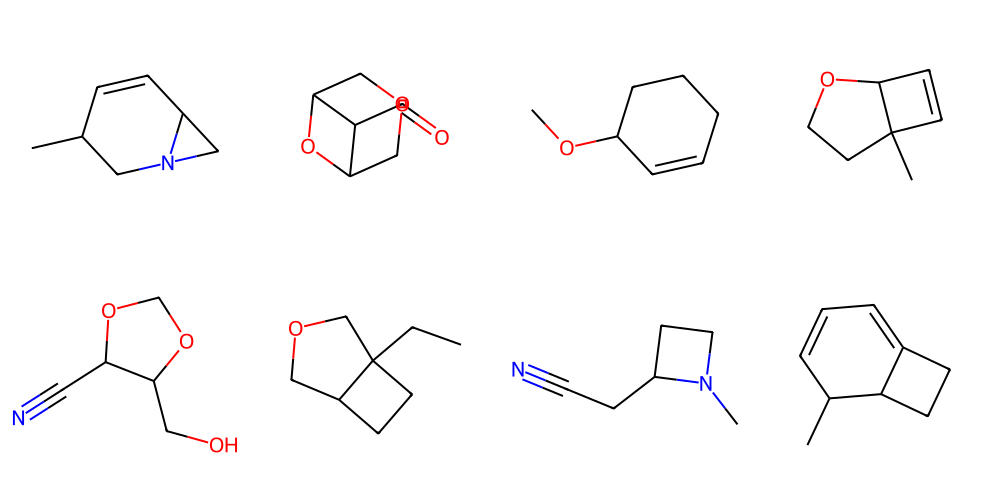

In [8]:
num_atoms = 25  # specify the number of atoms
smiles_list = gan_mol.generate_n(8, num_atoms)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)


In [14]:
import pandas as pd
from rdkit import Chem

# Assuming 'smiles_list' contains the SMILES strings and 'mol_list' contains RDKit molecules
data = []

for smiles, mol in zip(smiles_list, mol_list):
    if mol:  # Check if the molecule is valid
        mol_with_h = Chem.AddHs(mol)  # Add explicit hydrogens
        num_atoms = mol_with_h.GetNumAtoms()
        data.append({'SMILES': smiles, 'NumAtoms': num_atoms})
    else:
        data.append({'SMILES': smiles, 'NumAtoms': None})  # Handle invalid molecules

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


             SMILES  NumAtoms
0     O=C1OCC11COC1        14
1      CCC1=CNC=C1C        19
2      CC1CC11CCOC1        20
3       CCCC1OC1C#C        18
4       CC1CCN=COC1        19
5  O=C1CN2C=CNC2=C1        15
6      CC1COC11COC1        18
7       CC1CCOCC1=O        18


# Saving and loading model

In [20]:
# Save model
import torch
torch.save(gan_mol.state_dict(), 'gan_mol_dict.pth')


In [22]:
# Load model
# load data
data = []
with open('/kaggle/working/molgen_master/molgen-master/qm9.csv', "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

gan_mol_n = MolGen(data, hidden_dim=64, lr=1e-3, device="cuda")

# Load the state dictionary into the new model
gan_mol_n.load_state_dict(torch.load('gan_mol_dict.pth'))

# Print the loaded model state to verify
# print("Loaded model state:", gan_mol_n.state_dict())

<All keys matched successfully>

In [23]:
gan_mol_n.eval()

print('ok')

ok


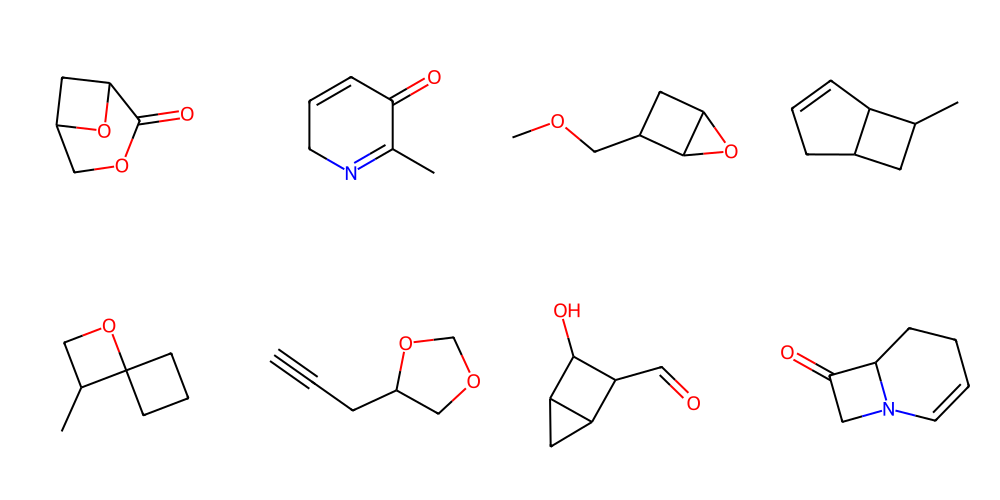

In [25]:
num_atoms = 25  # specify the number of atoms
smiles_list = gan_mol.generate_n(8, num_atoms)

# convert with rdkit
mol_list = [Chem.MolFromSmiles(m) for m in smiles_list]

# draw
Chem.Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(250, 250), maxMols=10)
